# Problem 1: More Powerful RNNs (30%)
RNNs are powerful tools for processing sequences. 
In this problem we'll explore a powerful variant/addition.


While powerful sequences processors, RNNs work one element at a time.
Therefore, RNNs can "miss out" on understanding a given word, if important context comes after 
that word in the sequence. 


Also, notice, that while reading backwards is more difficult, we can still learn a lot. For example

 - ```sanitizer hand bought and store the to went I yesterday```


In this problem, we'll make more powerful RNNs that can gain additional context by reading 
documents from beginning to end, as well as from end to beginning. 


## Part 0 Load the data

In [ ]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

import glob
import os

In [ ]:
import sys
sys.path.insert(0, ".")
from helpers import load_imdb_data_text


#(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text(...

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each


# your code here

## Part 1: Running in reverse
Create two identical LSTM models and fit them on the IMDB data. 
 - For the first, use our regular recipe
 - For the second, flip every document around so that the sequences are processed in reverse
   - the easiest way to flip the data is to use `np.fliplr` on the data as you feed it to your model


Comment on the results

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dropout, Dense
from keras.models import Model
import keras.backend as K

In [ ]:
K.clear_session()


# text_input = Input(shape=(MAX_SEQ_LEN,)....
# the model should
# - embed the word sequences to make a dense representation
# - use an LSTM (or two) to process the sequence
# - use dropout to help with overfitting
# - use one (or more) dense layers to get the output into the right shape

# compile the model

In [ ]:
import funcy


# here is a function you might find handy
def gen_data(x, y, batch_size, fliplr=False):
    """Generate data for our recurrent network
    
    Args:
        x: model inputs encoded as integer sequences
        y: targets (0/1)
        batch size: size of batch to yield
        fliplr: whether to flip the input data
    """
    idx = np.arange(x.shape[0])
    while True:
        np.random.shuffle(idx)
        for chunk in funcy.chunks(batch_size, idx):
            _x = x[chunk]
            _y = y[chunk]
            if fliplr:
                _x = np.flip(_x, axis=-1)
            yield _x, _y

In [ ]:

# generate a batch of data with fliplr=True
# turn it back into words (you can use `tokenizer.word_index`)
# make sure it looks like normal, backword english


In [ ]:
# fit the model, preserving the original order of the data

In [ ]:
# make an identical model and fit it, this time flipping the data

In [ ]:
# put comments here

## Part 2: The bidirectional LSTM
The idea behdind the bidirectional LSTM is to combine a forward and backward LSTM 
in order to reap the benefits of each. In such a scheme, we use two different LSTM
one that processes the sequence in the forward direction and one that processes it 
backward. We combine (concatenate) their outputs to get a more complex and hopefully 
better represntation of the sequence we're trying to process. 

# $ \\ $
# $ \\ $

![bidrectional lstm](../lectures/09_intro_to_neural/bi-lstm.jpg)

# $ \\ $
# $ \\ $

TODO: Make a model
 - One branch will take the embedded sequence and process it with an LSTM
 - Another branch will use a `Lambda` layer to flip the sequence and then process it with a different LSTM
   - __NB__: `keras.backed.reverse` is a helpful tensor operation
 - Concatenate the branches together
 - Use 1-2 dense layers to get the output into the right shape. 

This recipe will not require flipping the data before it goes into the model. 

### Plot the model in the notebook to confirm two branches that get combined

NB: you could also make __two__ different inputs to the model (one that gets flipped and one that doesn't) and process both with forward LSTMs. This approach is equivalent, but likely harder to implement.

In [ ]:
from keras.layers import Lambda, Concatenate

In [ ]:
K.clear_session()

# model code here
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")

# embed the sequence
# process the sequence with two different branches
#  - regular (forward) LSTM
#  - a layer that first flips the sequence and then an LSTM
# Dense layers to get the output in the right shape

embedded_sequence = Embedding(tokenizer.num_words + 1, 100)(text_input)

flip_layer = Lambda(... name="flipper")  # fix this line
flipped_sequence = flip_layer(embedded_sequence)

# more modeling code here

model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def plot_model_in_notebook(model):
    return SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

plot_model_in_notebook(model)

## Part 3: Fit the model
 - fit the model feeding in forward sequences. 
 - repeat for backward sequences (remember to re-initialize the model)

Comment on the results
 - how is the performance?
 - does the direction matter when we use a bidirectional lstm?

In [ ]:

# fit the model

In [ ]:
# reinitialize the model
# (just re-make it)

In [ ]:
# fit the model with reversed sequences

## Part 4: Use the keras builtin
In fact, keras has a builtin called `Bidirectional` which takes an RNN as an input
and returns a bidirectional version as the output. 

Use this to confirm that it works correctly. 
Comment on the number of parameters in the bidirectional LSTM

In [ ]:
from keras.layers import Bidirectional

In [ ]:
K.clear_session()
# make a model with a single Bidirectional LSTM using the keras builtin

In [ ]:
# fit the model

# Problem 2: Data Augmentation (30%)
Another way to prevent overfitting is to augment the data.
More data is always better, but sometimes we can't easily collect more data. 
A set of techniques to turn our current data set into a bigger one are called `data augmentation`. 

Data augmentation can take many forms, and are specific to the data and problem being solve. 
For example, in an image recognition problem, it is very common to rotate, crop, and zoom
images to generate new ones. We can think of this as a form of regularization, since we are, 
in some sense, forcing a pentalty if the model does not have rotation /scale invariance. 
In speech recognition, this can take the form of distoring an audio clip to have higher pitches
(e.g. speeding it up), which should "teach" a model that it should be pitch invariant. 

In text classification problems, it typcially a little more difficult to augment data. 
One common method is known as back-translation: if an autmated machine translation model is 
available, we can translate our text into one language (e.g. english to french) and then back
to the original language again (french to english). This typically yields a very similar 
piece of text to the original, but with different words. 

Here we'll try a simpler approach. In a low-data setting, we do not want the model to be too sensitive
to any given word. Accordingly, we can augment our data by creating additional examples which are 
identical to our current example, but with some words set to unknown words.

This problem is more opened ended.
TODO:
 - Load and process the IMDB sentiment data
 - train two identical models. In one of them, replace some fraction of the words with an unknown token (try `MAX_WORDS + 1`) as the integer encoding for the unknown token)
 - Discuss the results. 
   - What is the result of dropping words.
   - How does it compare to the image / audio methods described here

In [1]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

import sys
#sys.path.insert(0, ".")
#from helpers import load_imdb_data_text

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline


def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, 'train')
    test_dir = os.path.join(imdb_data_dir, 'test')

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename,'r', encoding='UTF-8') as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)


    texts = []
    targets = []
    for label in ('pos', 'neg'):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in files:
            with open(filename,'r', encoding='UTF-8') as fi:
                text = fi.read()
            target = (label == 'pos')
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]
    
    return (train_docs, y_train), (test_docs, y_test)

Populating the interactive namespace from numpy and matplotlib


In [3]:
MAX_SEQ_LEN = 125

In [4]:
import sys
sys.path.insert(0, ".")
#from helpers import load_imdb_data_text


(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('./data/aclImdb/')

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each


# your code here

C:\Users\shunl\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


In [6]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_docs)

train_sequences = tokenizer.texts_to_sequences(train_docs)
test_sequences = tokenizer.texts_to_sequences(test_docs)
type(train_sequences), len(train_sequences)

(list, 25000)

In [7]:
x_train = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, truncating="post")
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN, truncating="post")
x_train.shape, x_train.max()

((25000, 125), 49997)

In [8]:
UKNOWN_WORD = tokenizer.num_words + 1

In [9]:
from keras.layers import Dense, Input, Dropout, GRU, Embedding, LSTM
from keras.models import Model
import keras.backend as K

In [10]:
K.clear_session()


# modeling code here
# consider using
# - the right input shape
# - an embedding that takes us from an integer encoded word 
#   - NB max value is now tokenizer.num_words + 2 because of the unknown word
# - 1-2 LSTMs or GRUs
#  - remember, the last one needs `return_sequences=False`, the rest need it True
# - a Dense layer


# model code here
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
embedded_sequence = Embedding(tokenizer.num_words + 2, 100)(text_input)
# more code here

hidden_state = LSTM(7,return_sequences=True, activation="relu")(embedded_sequence)
hidden_state = GRU(7,return_sequences=False, activation="relu")(hidden_state)

output = Dense(1, activation="sigmoid")(hidden_state)

model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 125, 100)          5000200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 125, 7)            3024      
_________________________________________________________________
gru_1 (GRU)                  (None, 7)                 315       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 5,003,547
Trainable params: 5,003,547
Non-trainable params: 0
_________________________________________________________________


In [11]:
import funcy
def train_data_gen(batch_size, dropout_frac=0.):
    """training data geneator
    
    Args:
        batch size: size of batch to yield
        dropout_frac: fraction of words to replace with UKNOWN_WORD
    """
    
    x = x_train.copy()
    y = y_train.copy()
    # your code here
    dropout_len = int(x.shape[1] * dropout_frac) 
    for x_num in range(len(x)):
        for word in range(len(x[x_num])): 
            if word >= dropout_len:
                break
            x[x_num][word] = UKNOWN_WORD
            
            
    idx = np.arange(x.shape[0])    
      
    while True:
        np.random.shuffle(idx)  
        for chunk in funcy.chunks(batch_size, idx):
                
            yield x[chunk], y[chunk]


In [12]:
# fit the model
# use `dropout_frac=0`
batch_size = 256
model.fit_generator(train_data_gen(batch_size,0),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=x_test.shape[0] // batch_size,
                    validation_data=train_data_gen(batch_size,0),
                    epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
97/97 [==============================] - 30s 306ms/step - loss: 0.6646 - acc: 0.6412 - val_loss: 0.5790 - val_acc: 0.8173
Epoch 2/5
97/97 [==============================] - 28s 284ms/step - loss: 0.5309 - acc: 0.8235 - val_loss: 0.4061 - val_acc: 0.8752
Epoch 3/5
97/97 [==============================] - 28s 289ms/step - loss: 0.3282 - acc: 0.8892 - val_loss: 0.1949 - val_acc: 0.9406
Epoch 4/5
97/97 [==============================] - 28s 289ms/step - loss: 0.1877 - acc: 0.9400 - val_loss: 0.1182 - val_acc: 0.9714
Epoch 5/5
97/97 [==============================] - 28s 285ms/step - loss: 0.1101 - acc: 0.9712 - val_loss: 0.0702 - val_acc: 0.9869


In [13]:

# identical model code here
model2 = Model(text_input, output)
model2.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model2.fit_generator(train_data_gen(batch_size,0.2),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=x_test.shape[0] // batch_size,
                    validation_data=train_data_gen(batch_size,0),
                    epochs=5)
# fit it with dropout_frac > 0 (try 0.2 or 0.3)


Epoch 1/5
97/97 [==============================] - 31s 321ms/step - loss: 0.1063 - acc: 0.9681 - val_loss: 0.0528 - val_acc: 0.9902
Epoch 2/5
97/97 [==============================] - 28s 293ms/step - loss: 0.0594 - acc: 0.9855 - val_loss: 0.0380 - val_acc: 0.9934
Epoch 3/5
97/97 [==============================] - 31s 317ms/step - loss: 0.0366 - acc: 0.9919 - val_loss: 0.0352 - val_acc: 0.9932
Epoch 4/5
97/97 [==============================] - 31s 315ms/step - loss: 0.0401 - acc: 0.9893 - val_loss: 0.0297 - val_acc: 0.9952
Epoch 5/5
97/97 [==============================] - 28s 293ms/step - loss: 0.0299 - acc: 0.9932 - val_loss: 0.0404 - val_acc: 0.9926


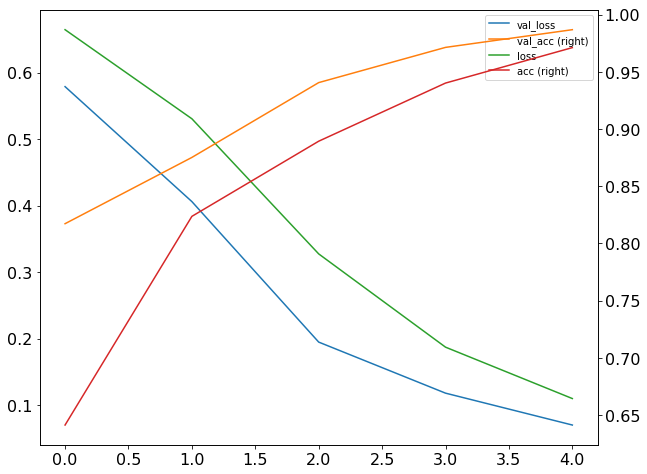

In [14]:
pd.DataFrame(model.history.history).plot(
    figsize=(10, 8), secondary_y=["acc", "val_acc"], fontsize=16
)

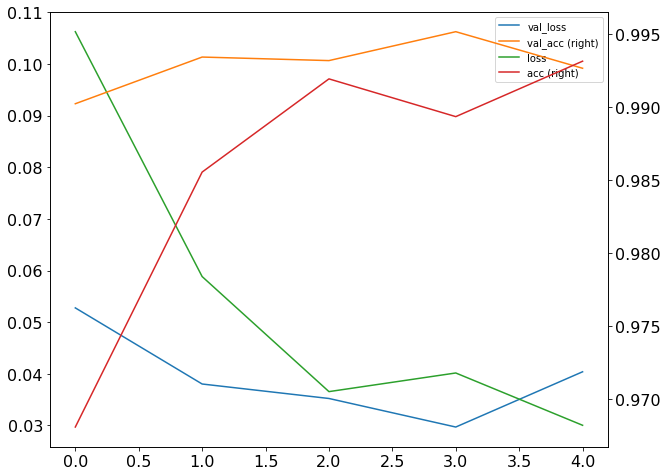

In [15]:
pd.DataFrame(model2.history.history).plot(
    figsize=(10, 8), secondary_y=["acc", "val_acc"], fontsize=16
)

In [240]:
# put comments here
#After the augment, the accuracy of the model increases, so it is worth to augment the data to make a better prediction.

# Problem 3: The Company Name Comparer (40%)
A common problem in NLP for finance is automatically comparing two company names to see if they are the same. 
Intuitively, this is a problem that is fairly easy for humans: 
 - `S and P Global` and `S&P Global`
 - `JPMorgan` and `JP Morgan`
 - `Google Inc.` and `Google`

However, the number of ways in which companies can be represented, and the intricacies of corporate 
structure make it difficult to craft rules to capture this behavior.
This makes the problem perfect for a machine learning approach. 
We will see that it is particularly well suited to deep learning, since some 
features will be difficult to craft by hand. 
In the end of this problem we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the two organizations refer to the same thing. 

In [ ]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

## Part 0: Load the data
Wikipedia is an excellent source of natural language data. 
We need a data set of many ways that we can refer to the same company.
Here we will use the page redicts- if a certain page automatically 
redirects to a second page, we can say with high confidence that the 
title of the first page unambiguously refers to the same thing as 
the second. The lack of ambiguity is important! For example, we 
do not want `Amazon` to be another way to refer to `amazon.com` since
it can also refer to the `amazon river`. See [here](https://en.wikipedia.org/wiki/Amazon) for more.

In `org_redirects.csv` you will find data on the page redirects that have been 
filtered down to everything considered an organization (this is not only companies, 
but it's close). The file has columns
 - `souce_id` a page id for the source page
 - `source_title`: the page title for the source
 - `target_id`: the page id for the page to which the source will redirect
 - `target_title`: the title of the page to which the source redirects
 - `target_qid`: the id of the page in wikidata, the accompanying knowledge graph to wikipedia
 - `edge_type`: the type of organization the target item has in wikidata

For our purposes, we can consider the `source_title` and `target_title` two 
ways to unambiguously refer to the same organization. We will teach an algorithm
to recognize the patterns in these data.


## TODO
 - ## 1. load the data
 - ## 2. Explore the data: 
   - ## what is the distribution of words / characters?
   - ## are there any tokens that are particularly common?
 



In [ ]:
df = pd.read_csv("../../data/org_redirects.csv")
print(df.shape)
df.head()

## Part 1: Process, Clean, and Filter
We need to have the data in slightly more usable form. 
For simplicity, we will want to only deal with lowercase characters. 
Additionally, we will want to remove special characters from the source
and target titles.

Additionally, some redirects require special knowledge, that we don't expect the 
algorithm to be able to learn. 

## TODO: 
 - create two new columns `source_clean` and `target_clean` which are lowercased versions of the original data with the characters `,_/` replaced by spaces
 - NB: remember to drop rows that are now duplicates because of the string cleaning we've done

In [ ]:
import re # probably a useful import 

def normalize_string(s):
    # your code here
    # normalize the data by lowercasing, and replace certain characters with whitespace
    # careful, replace 1 or more whitespace characters with a single whitespace

df["clean_source"] = df["source_title"].apply(normalize_string)
df["clean_target"] = df["target_title"].apply(normalize_string)

# drop the duplicates here. 
# you should have approx 1.1 million examples before dropping duplicates
# and approx 1.04 million examples after

## Part 2: Make training data
We only have positive examples, ie two ways of referring to the same organization. 
We need negative examples in order for the network to learn what is not considered the same orgnanization. 
There are many ways to do this, but we will use the most simple one- random examples from the training data. 

## TODO:
 - ## make another copy of our training data
 - ## shuffle either the source or target columns so that they no longer line up
 - ## add these new data as negative examples to the training data
 - ## split the data into two: train and test 


### Now we have a dataset with approximately 50% positive examples

## TODO (answers these questions in text)
 - ## What are the benefits of this approach
 - ## What are the downsides of this appoach
 - ## What would be a more sophisticated way to generate negative examples


In [ ]:
# wrangle the data here
# you should have approximately twice as many examples now
# the mean `y` value should be about 0.5

In [ ]:
# split randomly into train and test

In [ ]:
# comments here

## Part 3: Turn the data into numpy arrays
We will use a character level representation, since organizations have too
many special words to use a word-level representation. 

Eventually, we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the source and target refer to the same thing.

### TODO:
 - turn the data into sequences of characters that are integer encoded
   - use the `Tokenizer` with `char_level=True`
   - use `tokenizer.text_to_sequences` to turn the characters into integer-encoded sequences
 - pad the sequences to a constant length of 30 characters
 - write two functions, `train_gen` and `test_gen` which yield data for the network in the right form.
   - data should be yielded as `yield [input_1, input_2], output`
   - you will likely find it easier to have these functions one-hot-encode the characters on the fly instead of holding very large numpy arrays in memory.
 - test your functions and make sure you can recover the original input

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
def text_iterator():
    """This is a helpful iterator
    
    It will yield all the data in `clean_source` and `clean_target` 
    in the training data, without making another copy
    """
    for item in df_train["clean_source"]:
        yield item
    for item in df_train["clean_target"]:
        yield item


tok = Tokenizer(lower=True, char_level=True, num_words=140)
tok.fit_on_texts(text_iterator())

In [ ]:
MAX_SEQ_LEN = 30

In [ ]:
# for both train and test
#   for the src and target
#   - turn each into integer sequence
#   - pad the sequences 
# make y values for both train and test
print(x_train_targ.shape, x_test_targ.shape)

In [ ]:
MAX_CHARS = tok.num_words + 1

In [ ]:
from keras.utils import to_categorical
import funcy


def train_gen(batch_size):
    # your code here
    # the last line should probably look like
    #    `yield [batch_src, batch_targ], batch_y`
    
    # don't forget to one hot encode the characaters
    #   keras.utils.to_categorical is helpful (num_classes=MAX_CHARS)
    
    # if you're feeling enterprising, you can randomly flip
    # the source and target data, which serves as a way to augment
    # the training data. Consider                
#             if np.random.rand() > 0.5:
#                 batch_src, batch_targ = batch_targ, batch_src

            
            

def val_gen(batch_size):
    # your code here, it should be very similar to the function above
    # no need to flip the src and targets randomly

In [ ]:
# check the shapes, make sure you can recover the data and it looks normal

## Part 4: Build and fit a model
The beauty of keras is that it is flexible enough to allow us to do almost arbitrary matrix operations. 
In this model we will use several `Conv1D`-`MaxPooling1D` combinations to
encode or process the organization names. However, we will use the __SAME__ blocks for both 
the source and target names, in order to "force" the network to learn operations that
distill the strings down into features that make them easy to compare.

Build a keras model that 
 - has __two__ text inputs
 - has several conv/pooling blocks to process the inputs
 - uses the __same__ blocks to process both of the text inputs
 - concatentates the result of the convolutions together into one vector
 - use one or more `Dense` layers to output a single (`float`), which is the probability that the two organizations are the same

Hint: `keras.models.Model` can accept lists of inputs and outputs in addition to single tensors. 
 - `model = Model([input_1, input_2], output)`



In [ ]:
from keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    GlobalMaxPooling1D,
)
from keras.models import Model
import keras.backend as K

In [ ]:
K.clear_session()

do = 0.05



left = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))
right = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))


blocks = [
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    GlobalMaxPooling1D()
]

def encode(inpt):
    x = blocks[0](inpt)
    for block in blocks[1:]:
        x = block(x)
    return x

left_stream = encode(left)
right_stream = encode(right)
# TODO:
# - concatenate right and left streams
# - use 2-3 dense blocks to get the output into the right shape 
#    this is a binary classification problem
# - compile your model

# your code here

model = Model([left, right], your_output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# user these callbacks

In [ ]:
# fit the model

## Part 5: Analysis
We want to see how our new model works on unseen text. 
Write a function
```python
def compare_inputs(a, b):
    """takes in two strings and returns a float"""
    pass
```
that can use the model to compare two strings. 

TODO
 - Come up with at least 10 examples of your own and comment on the results

TODO: How would this be done without deep learning? 
 - Can we use the same operations on both the source and target?
 - How would we need to combine representations that come from the features we engineer from the two inputs?
 - If we had hand-engineered features, how would we add them to this network?

(answer in text below)

In [ ]:
def compare_inputs(a, b):
    # take two strings, process them the same way we process our training data
    # use `model.predict` to get a probability that they are the same
    # your code here

In [ ]:
for pair in [
    ("The college of Mann", "University of mann"),
    (...) # add lost more examples here
]:
    print("\"{}\" and \"{}\": {:.4f}".format(pair[0], pair[1], compare_inputs(*pair)[0][0]))

In [ ]:
# put analysis / comments here